# Hate speech detection

In [83]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from time import perf_counter
from collections import Counter
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
import voyageai
import re
from skimpy import skim
import emoji 
import math
import re
import nltk
from wordcloud import WordCloud
import gensim.downloader as api
import fasttext
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
tqdm.pandas()

In [ ]:
nltk.download('stopwords')
wv = api.load('glove-twitter-50')

# 1. Cleaning and visualizations

## We have a dataset of 700,000 rows, but due to time and resource constraints, I unfortunately cannot use all of this data. Therefore, we need to estimate how much data to retrieve. To do this, we will use **Hoeffding's inequality** with a tolerated error of 0.01 and a confidence level of 0.01 (which is equivalent to 99%)

## **$$ P(|\hat{p} - p| > \epsilon) \leq 2e^{-2N\epsilon^2} $$**

In [16]:
def calculate_hoeffding_samples(epsilon : float, delta : float) -> int:
    """
    Calculate the minimum number of samples required based on Hoeffding's Inequality.
    
    :param epsilon: The tolerance level (a small positive number).
    :param delta: The probability threshold for the confidence level.
    :return: The minimum number of samples required.
    """
    n = math.ceil(math.log(2/delta) / (2 * epsilon**2))
    return n

epsilon = 0.01  
delta = 0.01
n_samples = calculate_hoeffding_samples(epsilon, delta)
print(f'Minimum number of samples required: {n_samples}')


Minimum number of samples required: 26492


## We will therefore cap this value at **30,000** and retrieve a balanced sample (which means stratified in our case since the original dataset is already stratified) to work with

In [46]:
df = pd.read_csv('HateSpeechDatasetBalanced.csv')
df.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


In [25]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 726119 │ │ string      │ 1     │                                                          │
│ │ Number of columns │ 2      │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name        ┃ NA   ┃ NA %    ┃ mean    ┃ sd     ┃ p0   ┃ p25   ┃ p50   ┃ p75   ┃ p100    ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ Label              │    0 │       0 │     0.5 │    0.5 │    0 │     0 │     1 │     1 │       1 │  ▇    ▇  │  │
│ └────────────────────┴──────┴─────────┴─────────┴────────┴──────┴───────┴───────┴───────┴─────────┴──────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Content                   │       0 │          0 │                           36 │                 26383926 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

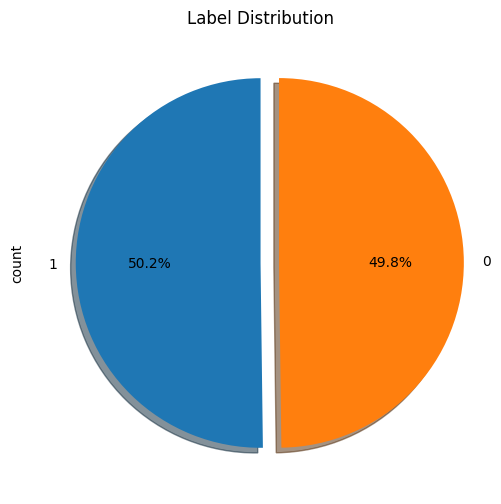

In [48]:
plt.figure(figsize=(6, 6))
df['Label'].value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, explode=(0, 0.1), startangle=90)
plt.title('Label Distribution')
plt.savefig('images/label_distribution_pie.png')
plt.show()

## As announced, we do indeed have a balanced dataset, and therefore we can retrieve a stratified sample of 30,000 data points

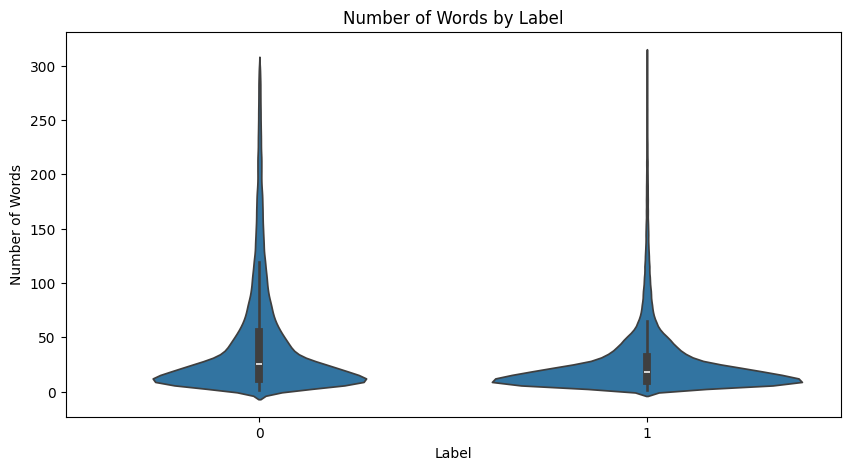

In [28]:
plt.figure(figsize=(10, 5))
sns.violinplot(data=df, x='Label', y=df['Content'].apply(lambda x: len(x.split())))
plt.title('Number of Words by Label')
plt.xlabel('Label')
plt.ylabel('Number of Words')
#plt.savefig('images/word_count.png')
plt.show()

## The figure above shows us that most of our texts have a character count between 10 and 50. This visualization will be useful later when we need to choose a padding and truncation strategy

In [29]:
df_train, df_test = train_test_split(df, train_size=30000, stratify=df['Label'], random_state=42)
df_test, df_val = train_test_split(df_test, train_size=10000,test_size=10000, stratify=df_test['Label'], random_state=42)
df_train.to_csv('data_train.csv', index=False)
df_test.to_csv('data_test.csv', index=False)
df_val.to_csv('data_val.csv', index=False)

In [43]:
df_train = pd.read_csv('data_train.csv')
df_test = pd.read_csv('data_test.csv')
df_val = pd.read_csv('data_val.csv')

In [44]:
df_train.isna().sum()

Content    0
Label      0
dtype: int64

In [45]:
def clean_text(text : str) -> str:
    """
    Clean the text by removing emojis, links, and special characters. Also, convert the text to lowercase, 
    remove stop words, and stem the words.
    :param text: The text to clean.
    """

    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    
    words = text.split()
    
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    stemmer = SnowballStemmer('english')
    words = [stemmer.stem(word) for word in words]
    
    cleaned_text = ' '.join(words)
    
    return cleaned_text

In [46]:
print('Cleaning text...')
print('Cleaning train set...')
df_train['Content'] = df_train['Content'].progress_apply(lambda x: clean_text(x))
print('Cleaning test set...')
df_test['Content'] = df_test['Content'].progress_apply(lambda x: clean_text(x))
print('Cleaning validation set...')
df_val['Content'] = df_val['Content'].progress_apply(lambda x: clean_text(x))
print('Done!')

Cleaning text...
Cleaning train set...


100%|██████████| 30000/30000 [00:18<00:00, 1647.40it/s]


Cleaning test set...


100%|██████████| 10000/10000 [00:06<00:00, 1621.92it/s]


Cleaning validation set...


100%|██████████| 10000/10000 [00:06<00:00, 1583.63it/s]

Done!


In [52]:
df_train = df_train[~ (df_train['Content'] == '')]
df_test = df_test[~ (df_test['Content'] == '')]
df_val = df_val[~ (df_val['Content'] == '')]


In [53]:
df_train.to_csv('data_train_cleaned.csv', index=False)
df_test.to_csv('data_test_cleaned.csv', index=False)
df_val.to_csv('data_val_cleaned.csv', index=False)

In [2]:
df_train = pd.read_csv('data_train_cleaned.csv')
df_test = pd.read_csv('data_test_cleaned.csv')
df_val = pd.read_csv('data_val_cleaned.csv')

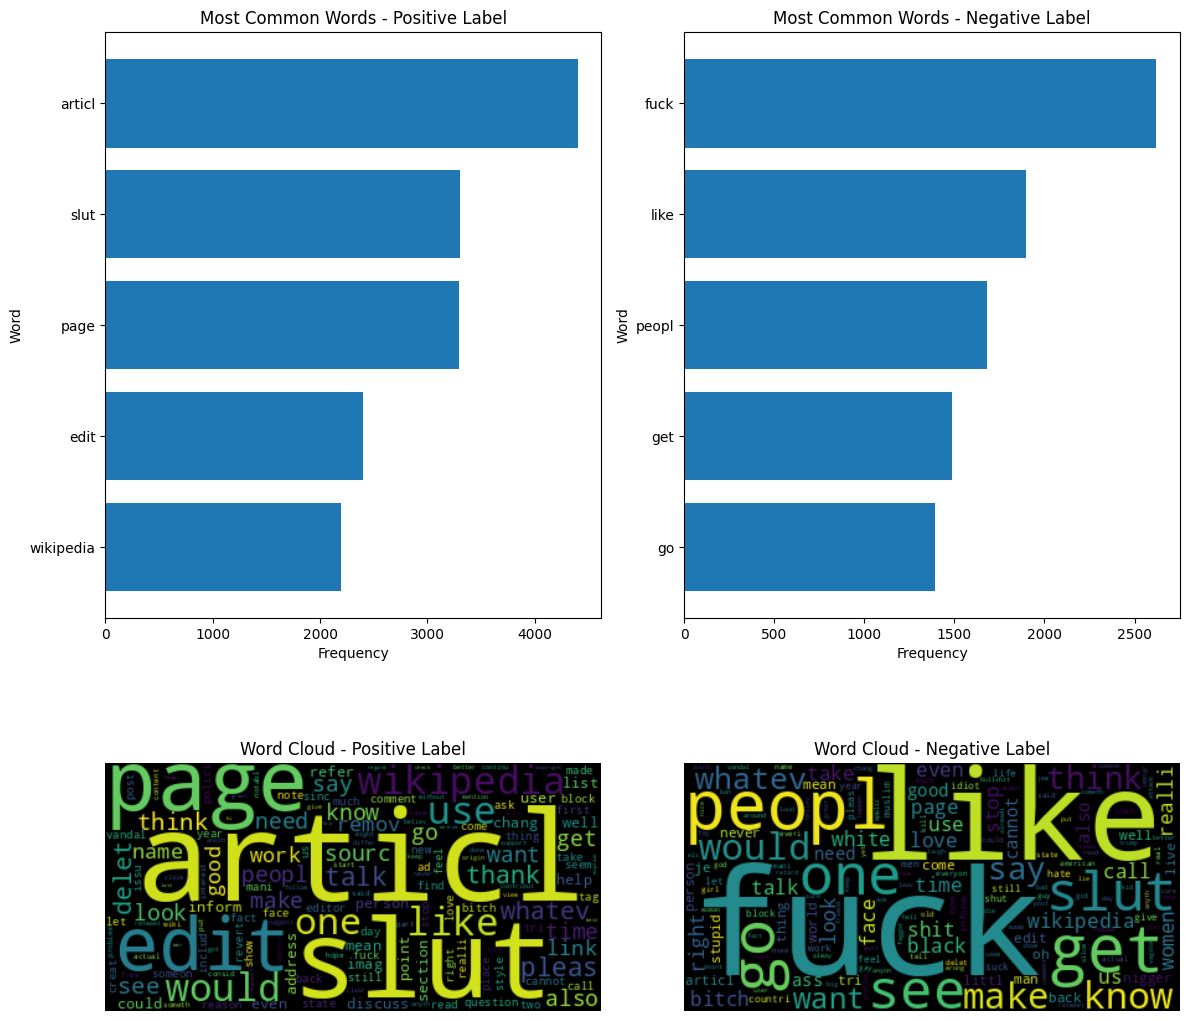

In [58]:
counter_positive = Counter(df_train[df_train['Label'] == 0]['Content'].str.split().sum())
counter_negative = Counter(df_train[df_train['Label'] == 1]['Content'].str.split().sum())

most_common_positive = counter_positive.most_common(5)[::-1]
most_common_negative = counter_negative.most_common(5)[::-1]

words_positive, frequencies_positive = zip(*most_common_positive)
words_negative, frequencies_negative = zip(*most_common_negative)

word_freq_positive = dict(counter_positive)
word_freq_negative = dict(counter_negative)

wordcloud_positive = WordCloud(background_color='black').generate_from_frequencies(word_freq_positive)
wordcloud_negative = WordCloud(background_color='black').generate_from_frequencies(word_freq_negative)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

axs[0, 0].barh(words_positive, frequencies_positive)
axs[0, 0].set_title('Most Common Words - Positive Label')
axs[0, 0].set_xlabel('Frequency')
axs[0, 0].set_ylabel('Word')

axs[0, 1].barh(words_negative, frequencies_negative)
axs[0, 1].set_title('Most Common Words - Negative Label')
axs[0, 1].set_xlabel('Frequency')
axs[0, 1].set_ylabel('Word')

axs[1, 0].imshow(wordcloud_positive, interpolation='bilinear')
axs[1, 0].set_title('Word Cloud - Positive Label')
axs[1, 0].axis('off')

axs[1, 1].imshow(wordcloud_negative, interpolation='bilinear')
axs[1, 1].set_title('Word Cloud - Negative Label')
axs[1, 1].axis('off')

# plt.savefig('images/wordcloud.png')
plt.tight_layout()
plt.show()

## The figure above shows us the most frequent words according to the label. Indeed, for negative messages, we can see an insult that is significantly more prevalent

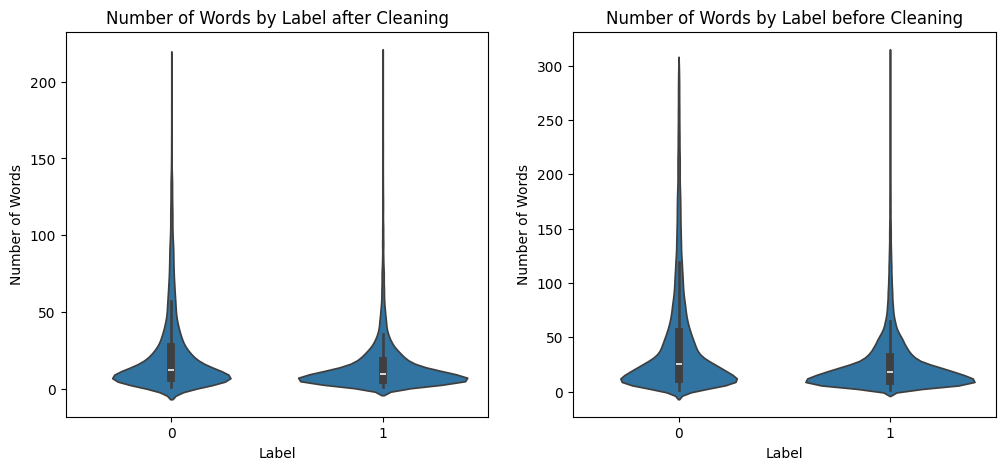

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.violinplot(data=df_train, x='Label', y=df_train['Content'].apply(lambda x: len(x.split())), ax=axs[0])
axs[0].set_title('Number of Words by Label after Cleaning')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Number of Words')

sns.violinplot(data=df, x='Label', y=df['Content'].apply(lambda x: len(x.split())), ax=axs[1])
axs[1].set_title('Number of Words by Label before Cleaning')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Number of Words')

#plt.savefig('images/word_count_cleaned_vs_non_cleaned.png')
plt.show()

## The figure above compares the distribution of the number of words for each label. We inevitably gain a few words, but the distributions remain very similar

## Now we will test different methods of embedding our texts:
### 1. TF-IDF
### 2. GloVe
### 3. fasttext
### 4. Transformer (Voyage-02)

In [9]:
tfidf = TfidfVectorizer(max_features=10000)
vo = voyageai.Client(api_key = "pa-jZ2eD-QY62LUv2QxaKNIKmJc8Ru-jON73ZNzOCRPeEM")

def tokenize(text):
    return [token for token in text.split()]

def vectorize_with_gloVe(text):
  vector_size = wv.vector_size
  wv_res = np.zeros(vector_size)
  cpt = 1
  for w in text:
    if w in wv:
      cpt+=1
      wv_res += wv[w]
  wv_res = wv_res/cpt
  return wv_res    

def ft_model():
  with open('tmp.txt', 'w') as f:
    for text in df_train['Content']:
      f.write(text + '\n')
  model = fasttext.train_unsupervised('tmp.txt', model='skipgram')
  return model

ft_model = ft_model()

def vectorize_with_fasttext(text):
  return ft_model.get_sentence_vector(text)

Read 0M words
Number of words:  8346
Number of labels: 0
Progress: 100.0% words/sec/thread:   37118 lr:  0.000000 avg.loss:  2.410800 ETA:   0h 0m 0s


In [17]:
print('Fitting TF-IDF...')
docs_tf_idf = tfidf.fit_transform(df_train['Content']).toarray()
print('Done!')
print('Embedding with GloVe...')
docs_glove = df_train['Content'].progress_apply(lambda x: vectorize_with_gloVe(tokenize(x))).tolist()
print('Done!')
print('Embedding with FastText...')
docs_ft = df_train['Content'].progress_apply(lambda x: vectorize_with_fasttext(x)).tolist()
print('Done!')
print('Embedding with Voyage...')
docs_batched = [df_train['Content'][i:i + 50].tolist() for i in range(0, len(df_train['Content']), 50)]
docs_voyage = []
for batch in tqdm(docs_batched):
    try:
        batch_embeddings = vo.embed(batch, model='voyage-02', input_type='document').embeddings
    except:
        batch_embeddings = vo.embed(batch, model='voyage-02', input_type='document').embeddings
    finally:
        docs_voyage.extend(batch_embeddings)
print('Done!')

Fitting TF-IDF...
Done!
Embedding with GloVe...


100%|██████████| 29956/29956 [00:01<00:00, 15857.39it/s]


Done!
Embedding with FastText...


100%|██████████| 29956/29956 [00:03<00:00, 9213.16it/s] 


Done!
Embedding with Voyage...


100%|██████████| 600/600 [06:18<00:00,  1.58it/s]

Done!


In [18]:
print('Length of TF-IDF vectors:', len(docs_tf_idf[0]))
print('Length of GloVe vectors:', len(docs_glove[0]))
print('Length of FastText vectors:', len(docs_ft[0]))
print('Length of Voyage vectors:', len(docs_voyage[0]))
print()
print('Number of TF-IDF vectors:', len(docs_tf_idf))
print('Number of GloVe vectors:', len(docs_glove))
print('Number of FastText vectors:', len(docs_ft))
print('Number of Voyage vectors:', len(docs_voyage))

Length of TF-IDF vectors: 10000
Length of GloVe vectors: 50
Length of FastText vectors: 100
Length of Voyage vectors: 1024

Number of TF-IDF vectors: 29956
Number of GloVe vectors: 29956
Number of FastText vectors: 29956
Number of Voyage vectors: 29956


In [19]:
df_with_vectors = df_train.copy()
#df_with_vectors['TF-IDF'] = docs_tf_idf.tolist()
df_with_vectors['GloVe'] = docs_glove
df_with_vectors['FastText'] = docs_ft
df_with_vectors['Voyage'] = docs_voyage
df_with_vectors.to_csv('data_train_with_vectors.csv', index=False)
df_with_vectors.head()

,Content,Label,GloVe,FastText,Voyage
0,merg discuss slut merg discuss page ever held ...,0,"[0.396307966417887, 0.3437552653591741, 0.1330...","[-0.0035605454, 0.014184192, 0.11041838, 0.000...","[0.020471060648560524, 0.003549023065716028, -..."
1,dunno look okay like,0,"[0.23359980136156083, 0.12730599641799928, 0.1...","[-0.025828073, 0.050922208, 0.06824672, 0.0036...","[0.014980827458202839, 0.0034704094287008047, ..."
2,ipak odustajem haha hahaha,0,"[0.8878275007009506, 0.22010250389575958, 0.32...","[-0.0016325682, 0.034874726, 0.039830297, 0.03...","[0.013682648539543152, 0.019817529246211052, -..."
3,moslem terrorist rather vigilant killer whale,1,"[-0.35405429133347105, 0.21748528948851995, -0...","[-0.05810004, -0.0030582375, -0.033672076, 0.0...","[0.022014306858181953, 0.004979489371180534, -..."
4,meant claim fuck boi bwhahhahahaha,1,"[0.33812599182128905, 0.3702240020036697, -0.0...","[-0.08520477, -0.0109668365, 0.08665824, -0.01...","[0.023333314806222916, 0.00996093638241291, -0..."


In [ ]:
df_with_vectors = pd.read_csv('data_train_with_vectors.csv')

In [25]:
pca = PCA(n_components=2)
svd = TruncatedSVD(n_components=2)
embed_list = ['GloVe', 'FastText', 'Voyage','TF-IDF']
df_dict = {}

for embed in tqdm(embed_list):
    if embed == 'TF-IDF':
        tmp_feat = svd.fit_transform(docs_tf_idf)
    else:
        tmp_feat = pca.fit_transform(df_with_vectors[embed].tolist())
    df_dict[embed] = pd.DataFrame({'X1': tmp_feat[:, 0], 'X2': tmp_feat[:, 1], 'Label': df_with_vectors['Label']})

100%|██████████| 4/4 [00:14<00:00,  3.55s/it]


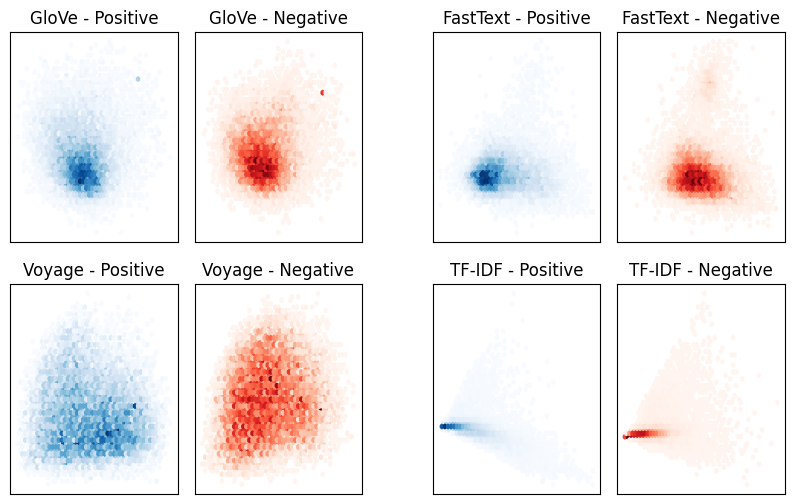

In [45]:
fig = plt.figure(figsize=(10, 6))

outer_grid = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)

for i, (embed, df) in enumerate(df_dict.items()):
    inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[i], wspace=0.1, hspace=0.1)
    
    df_0 = df[df['Label'] == 0]
    df_1 = df[df['Label'] == 1]

    for j in range(2):
        ax = plt.Subplot(fig, inner_grid[j])
        fig.add_subplot(ax)
        
        if j == 0:
            ax.hexbin(df_0['X1'], df_0['X2'], gridsize=50, cmap='Blues', mincnt=1)
            ax.set_title(f'{embed} - Positive')
        else:
            ax.hexbin(df_1['X1'], df_1['X2'], gridsize=50, cmap='Reds', mincnt=1)
            ax.set_title(f'{embed} - Negative')
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['top'].set_visible(True)

#plt.savefig('images/embeddings_pca.png')
plt.show()


## Although it is subtle, we still notice trends in orientation depending on the label, especially for `voyage` and `fasttext`

# 2. Modeling
### For the metrics, we will use everything that is specific to classification (`accuracy`, `precision`, `recall`, `f1`, `confusion matrix`). Accuracy is relevant due to the balance of our data

### We must first prepare the test and validation sets

In [54]:
print('Fitting TF-IDF...')
docs_tf_idf_test = tfidf.fit_transform(df_test['Content']).toarray()
docs_tf_idf_val = tfidf.fit_transform(df_val['Content']).toarray()
print('Done!')
print('Embedding with GloVe...')
docs_glove_test = df_test['Content'].progress_apply(lambda x: vectorize_with_gloVe(tokenize(x))).tolist()
docs_glove_val = df_val['Content'].progress_apply(lambda x: vectorize_with_gloVe(tokenize(x))).tolist()
print('Done!')
print('Embedding with FastText...')
docs_ft_test = df_test['Content'].progress_apply(lambda x: vectorize_with_fasttext(x)).tolist()
docs_ft_val = df_val['Content'].progress_apply(lambda x: vectorize_with_fasttext(x)).tolist()
print('Done!')
print('Embedding with Voyage...')
docs_batched_test = [df_test['Content'][i:i + 50].tolist() for i in range(0, len(df_test['Content']), 50)]
docs_voyage_test = []
for batch in tqdm(docs_batched_test):
    try:
        batch_embeddings = vo.embed(batch, model='voyage-02', input_type='document').embeddings
    except:
        batch_embeddings = vo.embed(batch, model='voyage-02', input_type='document').embeddings
    finally:
        docs_voyage_test.extend(batch_embeddings)
docs_batched_val = [df_val['Content'][i:i + 50].tolist() for i in range(0, len(df_val['Content']), 50)]
docs_voyage_val = []
for batch in tqdm(docs_batched_val):
    try:
        batch_embeddings = vo.embed(batch, model='voyage-02', input_type='document').embeddings
    except:
        batch_embeddings = vo.embed(batch, model='voyage-02', input_type='document').embeddings
    finally:
        docs_voyage_val.extend(batch_embeddings)
print('Done!')

Fitting TF-IDF...
Done!
Embedding with GloVe...


100%|██████████| 9984/9984 [00:00<00:00, 15121.41it/s]


Done!
Embedding with FastText...


100%|██████████| 9984/9984 [00:01<00:00, 9667.83it/s] 


Done!
Embedding with Voyage...


100%|██████████| 200/200 [01:53<00:00,  1.76it/s]

Done!


In [59]:
print('Test Set Embeddings Shape', end='\n\n')
print('Length of TF-IDF vectors:', len(docs_tf_idf_test[0]))
print('Length of GloVe vectors:', len(docs_glove_test[0]))
print('Length of FastText vectors:', len(docs_ft_test[0]))
print('Length of Voyage vectors:', len(docs_voyage_test[0]))
print()
print('Number of TF-IDF vectors:', len(docs_tf_idf_test))
print('Number of GloVe vectors:', len(docs_glove_test))
print('Number of FastText vectors:', len(docs_ft_test))
print('Number of Voyage vectors:', len(docs_voyage_test))
print('\n\n')
print('Validation Set Embeddings Shape', end='\n\n')
print('Length of TF-IDF vectors:', len(docs_tf_idf_val[0]))
print('Length of GloVe vectors:', len(docs_glove_val[0]))
print('Length of FastText vectors:', len(docs_ft_val[0]))
print('Length of Voyage vectors:', len(docs_voyage_val[0]))
print()
print('Number of TF-IDF vectors:', len(docs_tf_idf_val))
print('Number of GloVe vectors:', len(docs_glove_val))
print('Number of FastText vectors:', len(docs_ft_val))
print('Number of Voyage vectors:', len(docs_voyage_val))

Test Set Embeddings Shape

Length of TF-IDF vectors: 10000
Length of GloVe vectors: 50
Length of FastText vectors: 100
Length of Voyage vectors: 1024

Number of TF-IDF vectors: 9987
Number of GloVe vectors: 9987
Number of FastText vectors: 9987
Number of Voyage vectors: 9987



Validation Set Embeddings Shape

Length of TF-IDF vectors: 10000
Length of GloVe vectors: 50
Length of FastText vectors: 100
Length of Voyage vectors: 1024

Number of TF-IDF vectors: 9984
Number of GloVe vectors: 9984
Number of FastText vectors: 9984
Number of Voyage vectors: 9984


In [60]:
df_with_vectors_test = df_test.copy()
#df_with_vectors_test['TF-IDF'] = docs_tf_idf_test.tolist()
df_with_vectors_test['GloVe'] = docs_glove_test
df_with_vectors_test['FastText'] = docs_ft_test
df_with_vectors_test['Voyage'] = docs_voyage_test
df_with_vectors_test.to_csv('data_test_with_vectors.csv', index=False)

df_with_vectors_val = df_val.copy()
#df_with_vectors_val['TF-IDF'] = docs_tf_idf_val.tolist()
df_with_vectors_val['GloVe'] = docs_glove_val
df_with_vectors_val['FastText'] = docs_ft_val
df_with_vectors_val['Voyage'] = docs_voyage_val
df_with_vectors_val.to_csv('data_val_with_vectors.csv', index=False)

## First, we will build our initial models using the embeddings we have.

### First, we will try the naive Bayes models. 

In [73]:
# Multinomial Naive Bayes & Bernoulli Naive Bayes are used for TF-IDF vectors
mnb = MultinomialNB()
bnb = BernoulliNB()
gnb = GaussianNB()

In [80]:
model_scores = {
    'Multinomial Naive Bayes': {embed: {} for embed in embed_list},
    'Gaussian Naive Bayes': {embed: {} for embed in embed_list},
    'Bernoulli Naive Bayes': {embed: {} for embed in embed_list},
}

In [81]:
for embed in tqdm(embed_list):
    y_train = df_with_vectors['Label'].tolist()
    y_test = df_with_vectors_test['Label'].tolist()
    if embed == 'TF-IDF':
        X_train = docs_tf_idf
        mnb.fit(X_train, y_train)
        bnb.fit(X_train, y_train)
        X_test = docs_tf_idf_test
        start = perf_counter()
        preds = mnb.predict(X_test)
        end = perf_counter() - start
        model_scores['Multinomial Naive Bayes']['TF-IDF']['accuracy'] = accuracy_score(y_test, preds)
        model_scores['Multinomial Naive Bayes']['TF-IDF']['f1'] = f1_score(y_test, preds)
        model_scores['Multinomial Naive Bayes']['TF-IDF']['precision'] = precision_score(y_test, preds)
        model_scores['Multinomial Naive Bayes']['TF-IDF']['recall'] = recall_score(y_test, preds)
        model_scores['Multinomial Naive Bayes']['TF-IDF']['time'] = end

        start = perf_counter()
        preds = bnb.predict(X_test)
        end = perf_counter() - start
        model_scores['Bernoulli Naive Bayes']['TF-IDF']['accuracy'] = accuracy_score(y_test, preds)
        model_scores['Bernoulli Naive Bayes']['TF-IDF']['f1'] = f1_score(y_test, preds)
        model_scores['Bernoulli Naive Bayes']['TF-IDF']['precision'] = precision_score(y_test, preds)
        model_scores['Bernoulli Naive Bayes']['TF-IDF']['recall'] = recall_score(y_test, preds)
        model_scores['Bernoulli Naive Bayes']['TF-IDF']['time'] = end
    else:
        X_train = df_with_vectors[embed].tolist()
        gnb.fit(X_train, y_train)
        X_test = df_with_vectors_test[embed].tolist()
        start = perf_counter()
        preds = gnb.predict(X_test)
        end = perf_counter() - start
        model_scores['Gaussian Naive Bayes'][embed]['accuracy'] = accuracy_score(y_test, preds)
        model_scores['Gaussian Naive Bayes'][embed]['f1'] = f1_score(y_test, preds)
        model_scores['Gaussian Naive Bayes'][embed]['precision'] = precision_score(y_test, preds)
        model_scores['Gaussian Naive Bayes'][embed]['recall'] = recall_score(y_test, preds)
        model_scores['Gaussian Naive Bayes'][embed]['time'] = end

100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


In [85]:
print(model_scores)

{'Multinomial Naive Bayes': {'GloVe': {}, 'FastText': {}, 'Voyage': {}, 'TF-IDF': {'accuracy': 0.5124662060678883, 'f1': 0.4795296632816676, 'precision': 0.5163443830570903, 'recall': 0.4476152464577929, 'time': 0.250804467999842}}, 'Gaussian Naive Bayes': {'GloVe': {'accuracy': 0.6776809852808652, 'f1': 0.675274891556542, 'precision': 0.6827825377396981, 'recall': 0.6679305527838755, 'time': 0.014970323001762154}, 'FastText': {'accuracy': 0.7282467207369581, 'f1': 0.7326635145784082, 'precision': 0.7234001167088115, 'recall': 0.7421672320894033, 'time': 0.019951791000494268}, 'Voyage': {'accuracy': 0.7078201662160809, 'f1': 0.7180676328502416, 'precision': 0.6960104888555909, 'recall': 0.7415685491917781, 'time': 0.7278417849993275}, 'TF-IDF': {}}, 'Bernoulli Naive Bayes': {'GloVe': {}, 'FastText': {}, 'Voyage': {}, 'TF-IDF': {'accuracy': 0.5576249123861019, 'f1': 0.6213575591360987, 'precision': 0.544539582394472, 'recall': 0.7234085012971463, 'time': 0.889656109000498}}}


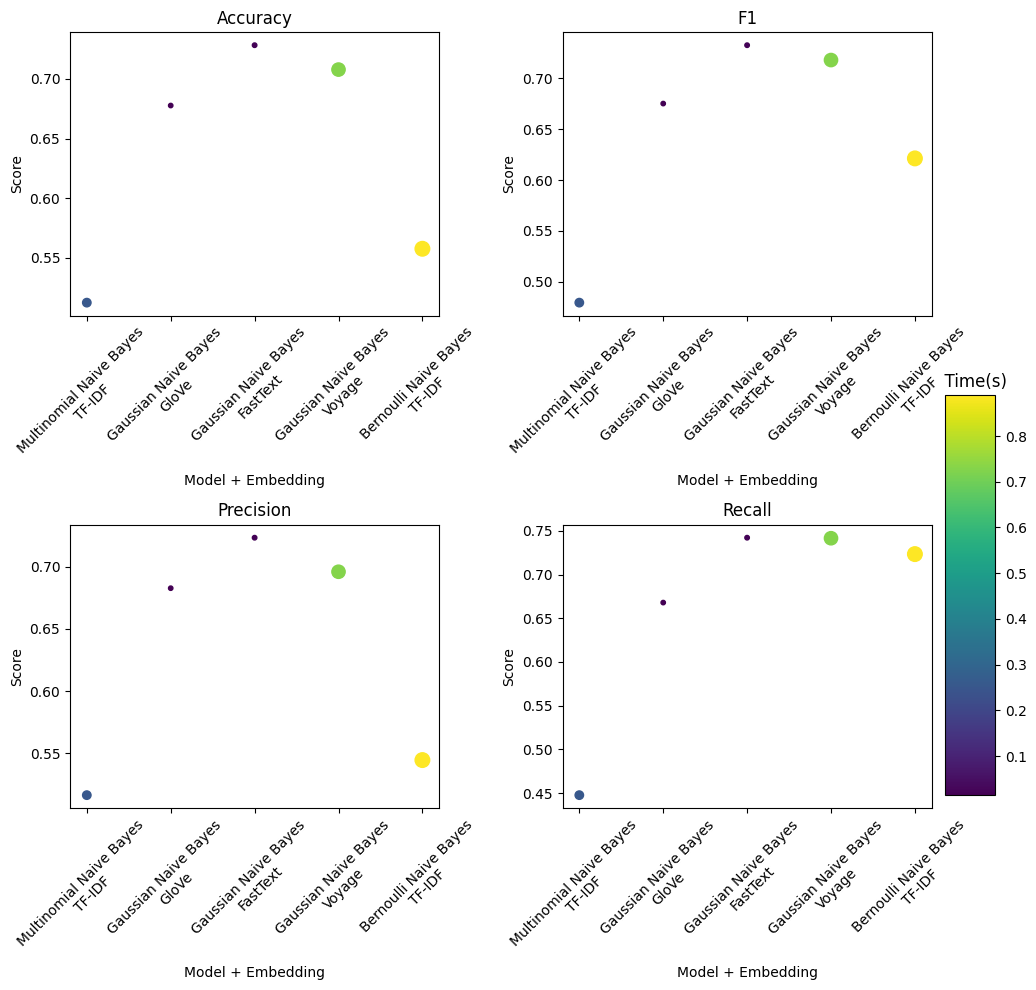

In [124]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

metrics = ['accuracy', 'f1', 'precision', 'recall']
model_embeddings = []
scores = {metric: [] for metric in metrics}
times = []

for model in model_scores:
    for embed in model_scores[model]:
        if not model_scores[model][embed]:
            continue

        model_embeddings.append(f"{model}\n{embed}")
        for metric in metrics:
            scores[metric].append(model_scores[model][embed].get(metric, None))
        times.append(model_scores[model][embed].get('time', None))

clean_indices = [i for i, t in enumerate(times) if t is not None]
model_embeddings = [model_embeddings[i] for i in clean_indices]
times = [times[i] for i in clean_indices]
for metric in metrics:
    scores[metric] = [scores[metric][i] for i in clean_indices]

times = np.array(times)
sizes = (times - times.min()) / (times.max() - times.min()) * 100 + 10  

for ax, metric in zip(axs, metrics):
    sc = ax.scatter(model_embeddings, scores[metric], c=times, cmap='viridis', s=sizes)
    ax.set_title(metric.capitalize())
    ax.set_xlabel('Model + Embedding')
    ax.set_ylabel('Score')
    ax.set_xticklabels(model_embeddings, rotation=45)

cbar = fig.colorbar(sc, ax=axs, cax=fig.add_axes([0.95, 0.2, 0.05, 0.4]), aspect=10)
cbar.ax.set_title('  Time(s)')

plt.tight_layout()
#plt.savefig('images/naive_bayes.png')
plt.show()

### We notice that among the four metrics, the model performing the best is `FastText+GaussianNB`. It has the best inference time and the best results. We can note the slowness of inference with the Voyage embeddings, in addition to the fact that their performance does not surpass that of GloVe by much. **Let's recall the embeddings sizes (50 for GloVe and 1024 for Voyage-02)**